#Importo le librerie e i pacchetti necessari

In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Definisco alcune funzioni

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
def UCM_model(lev_tre, train, validation, covid):
  if covid==0:
    model = sm.tsa.UnobservedComponents(train['Value'],
                                        lev_tre,
                                        seasonal=24, freq_seasonal = [{'period':24*7, 'harmonics':15}])
    model = model.fit(low_memory=True)
    
    # predict for evaluate on VALIDATION
    predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1])
    predicted_val_mean = predicted_val.predicted_mean
    residui_val=validation['Value']-predicted_val_mean   
  
  
  elif covid==1:
    model = sm.tsa.UnobservedComponents(train['Value'],
                                        lev_tre,
                                        exog=np.array(data_info['covid'])[:len(train)],
                                        seasonal=24, freq_seasonal = [{'period':24*7, 'harmonics':15}])  
    model = model.fit()

    # predict for evaluate on VALIDATION
    predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1], 
                                        exog=np.array(data_info['covid'])[len(train):,].reshape(len(validation), 1))
    predicted_val_mean = predicted_val.predicted_mean
    residui_val=validation['Value']-predicted_val_mean
  
  min=model.loglikelihood_burn
  # predict for evaluate on TRAIN
  predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
  predicted_train_mean = predicted_train.predicted_mean
  residui_train=train['Value'][min:]-predicted_train_mean

  print("level-trend: {}" .format(lev_tre))
  print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
  print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean), '\n')

In [ ]:
def plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min):
  # prediction on TRAIN
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN')
  plt.plot(train['Value'][min:], color='dimgrey', label='Real')
  plt.plot(predicted_train_mean[min:], color='darkred', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['Value'], color='dimgrey', label='Train')
  plt.plot(validation['Value'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['Value'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['Value'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['Value'][-800:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[-800:], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

#Importo i dati

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/streaming data management/progetto')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)

In [ ]:
data_fest=pd.read_csv('data_fest.csv', sep=',', low_memory=False, parse_dates=['Date_Hour'])
data_fest.set_index('Date_Hour', inplace=True)

In [ ]:
data_info=pd.read_csv('data_info.csv', sep=',', low_memory=False, parse_dates=['Date_Hour'])
data_info.set_index('Date_Hour', inplace=True)

In [ ]:
train=data.loc[:"2020-04-30 23:00:00"]
validation=data.loc["2020-05-01 00:00:00":]

# Modello UCM in forma state space

Per determinare il miglior tipo di level-trend uso un approccio grid search. 

I modelli migliori risultano quelli che presentano un level-trend del tipo random walk, local level, local linear deterministic trend, random walk with drift.
La stagionalità giornaliera è rappresentata tramite variabili dummy e quella settimanale tramite serie di fourier.


In [ ]:
#whitout covid variable
for lev_tre in ['rwalk', 'dconstant', 'ntrend', 'llevel', 'lldtrend', 'rwdrift', 'lltrend', 'strend', 'rtrend']:
  UCM_model(lev_tre, train, validation, covid=0)

level-trend: rwalk
MAE train: 102648.6
MAE validation: 752061.9 

level-trend: dconstant
MAE train: 1023575.9
MAE validation: 3645172.2 

level-trend: ntrend
MAE train: 1023536.3
MAE validation: 3645233.1 

level-trend: llevel
MAE train: 103983.0
MAE validation: 752009.1 

level-trend: lldtrend
MAE train: 103958.2
MAE validation: 742714.1 

level-trend: rwdrift
MAE train: 102623.3
MAE validation: 743458.6 

level-trend: lltrend
MAE train: 105028.5
MAE validation: 13418369.2 

level-trend: strend
MAE train: 105031.0
MAE validation: 13418507.5 

level-trend: rtrend
MAE train: 103951.7
MAE validation: 13096502.3 



In [ ]:
#with covid variable
for lev_tre in ['rwalk', 'llevel', 'lldtrend', 'rwdrift']:
  UCM_model(lev_tre, train, validation, covid=1)

level-trend: rwalk
MAE train: 102647.7
MAE validation: 752061.9 

level-trend: llevel
MAE train: 103982.1
MAE validation: 752009.1 

level-trend: lldtrend
MAE train: 103957.4
MAE validation: 742704.8 

level-trend: rwdrift
MAE train: 102622.4
MAE validation: 743449.3 



Come modello migliore, che utilizzerò anche per fare le previsioni, ho scelto un modello con level-trend di tipo random walk with drift. Analizziamo i risultati graficamente.

In [ ]:
model = sm.tsa.UnobservedComponents(train['Value'],
                                    'rwdrift',
                                    seasonal=24, freq_seasonal = [{'period':24*7, 'harmonics':15}])
model = model.fit(low_memory=True)

In [ ]:
min=model.loglikelihood_burn
# predict for evaluate on TRAIN
predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
predicted_train_mean = predicted_train.predicted_mean
residui_train=train['Value'][min:]-predicted_train_mean

# predict for evaluate on VALIDATION
predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1])
predicted_val_mean = predicted_val.predicted_mean
residui_val=validation['Value']-predicted_val_mean

print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean))

MAE train: 102623.3
MAE validation: 743458.6


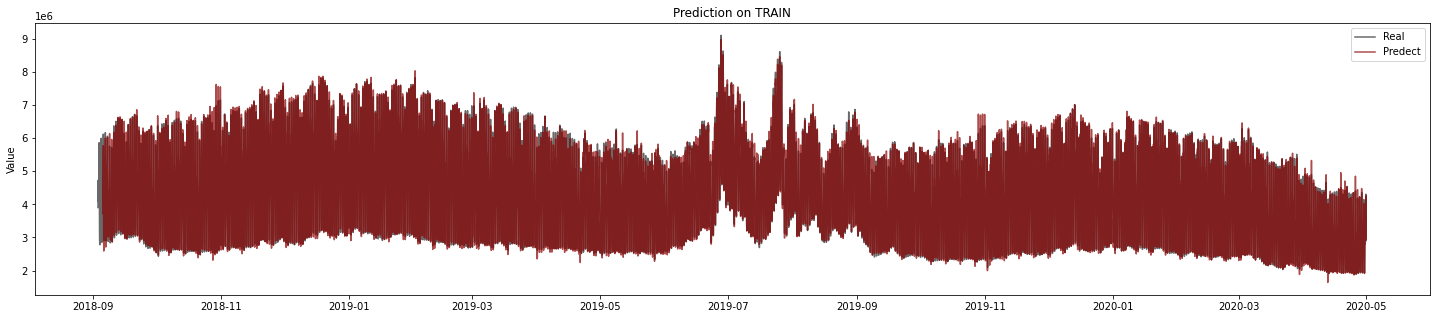

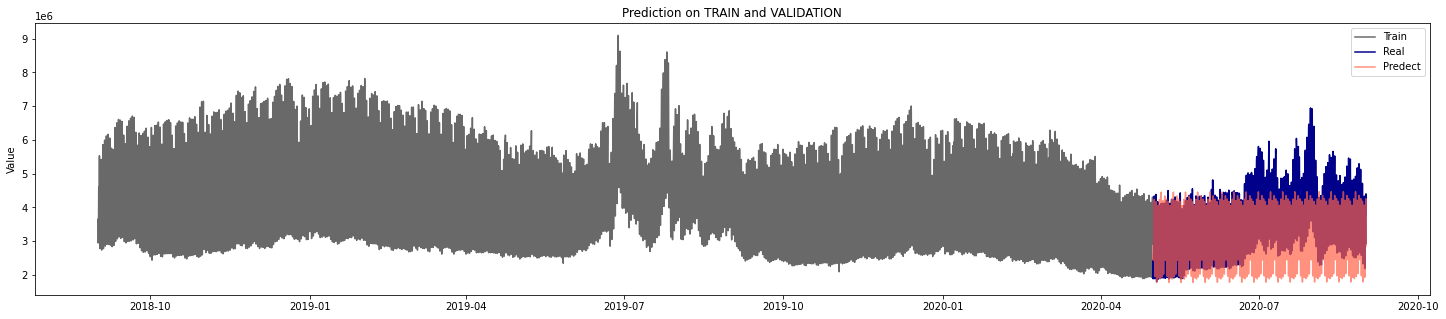

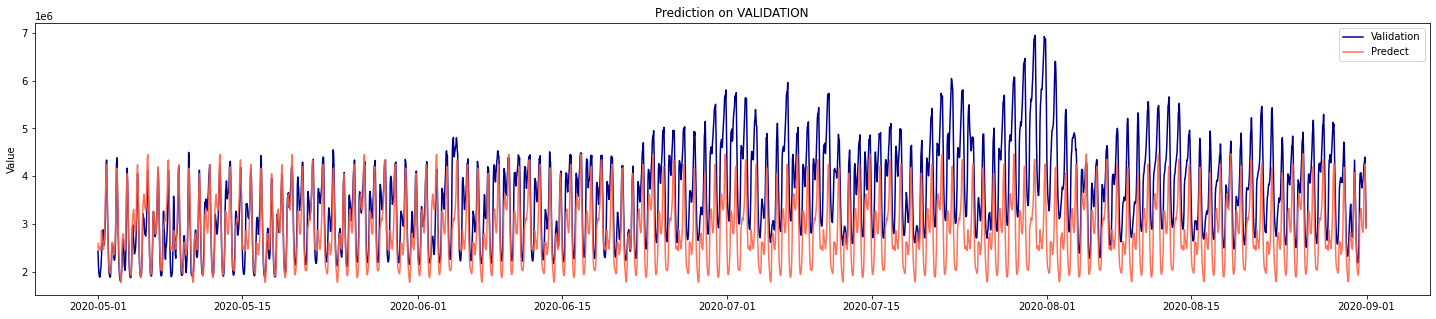

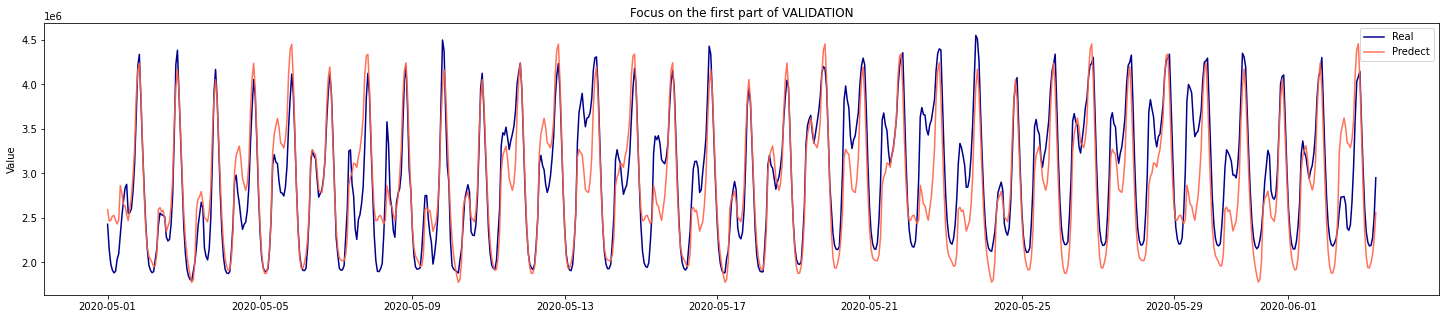

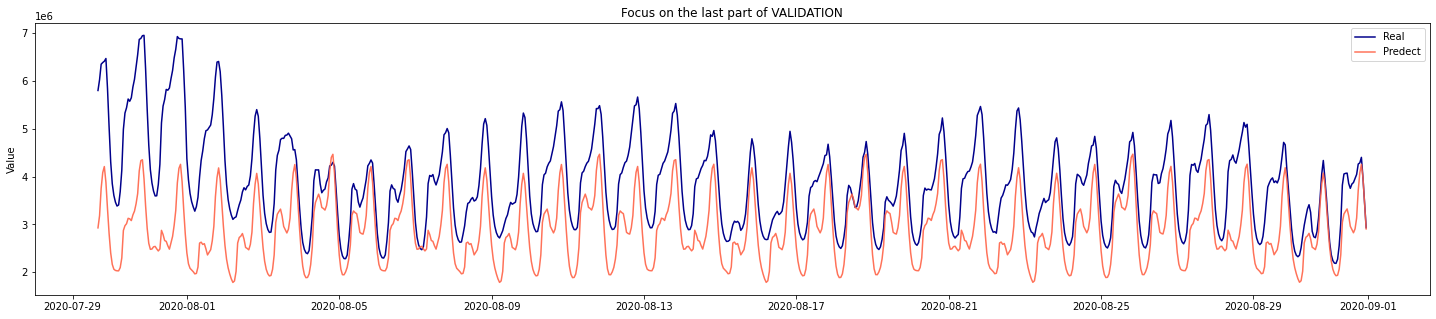

In [ ]:
plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min)

Come si vede dai grafici sul train e sul test il modello interpreta bene la stagionalità giornaliera e settimanale. Manca però quella annua.
Avrei potuto aggiungere una stagionalità annua tramite serie di fourier ma così facendo il fit esaurisce tutta la RAM disponibile di Colab e crasha.
Provando anchead aggiungere un ciclo il modello non migliora in termini di MAE sul train e sul validation set. 

Per fare le previsioni scelgo un modello con level-trend di tipo random walk with drift.

# Previsioni

In [ ]:
model_tot = sm.tsa.UnobservedComponents(data['Value'],
                                    'rwdrift',
                                    seasonal=24, freq_seasonal = [{'period':24*7, 'harmonics':15}])
model_tot = model_tot.fit(low_memory=True)

In [ ]:
future = model_tot.get_prediction(start=pd.to_datetime('2020-09-01-0',  format = "%Y-%m-%d-%H"),
                                end=pd.to_datetime('2020-10-31-23',  format = "%Y-%m-%d-%H"))

In [ ]:
forecast = pd.DataFrame({'UCM':future.predicted_mean, 
                         'Date':pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H')})

In [ ]:
forecast.to_csv('UCM.csv')